In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape, 
                                     GRU, TimeDistributed, GlobalAveragePooling1D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.preprocessing import label_binarize

In [2]:
# Define dataset paths
train_dir = "ankit/train"  # Replace with the actual path to your train folder
test_dir = "ankit/test"    # Replace with the actual path to your test folder

In [3]:
# Data exploration
data_generator_exploration = ImageDataGenerator(rescale=1.0/255)
train_data = data_generator_exploration.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    shuffle=True
)

Found 28709 images belonging to 7 classes.


C:\Users\Mayank\AppData\Local\Temp\ipykernel_3240\1339441238.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=class_counts, palette="rainbow")


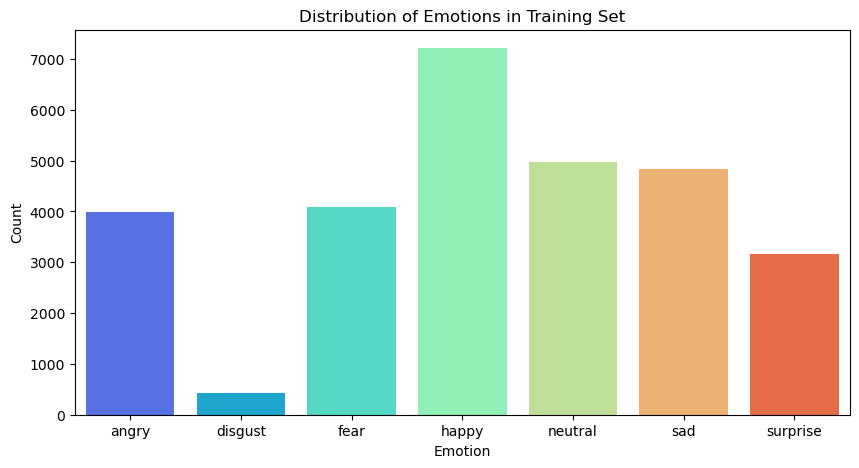

In [4]:
# Visualizing class distribution
class_labels = list(train_data.class_indices.keys())
class_counts = [np.sum(train_data.classes == i) for i in range(len(class_labels))]

plt.figure(figsize=(10, 5))
sns.barplot(x=class_labels, y=class_counts, palette="rainbow")
plt.title("Distribution of Emotions in Training Set")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

In [5]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

In [6]:
# Load the data
batch_size = 64
img_size = (48, 48)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
# Hybrid CNN-RNN model definition
def cnn_rnn_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    # CNN block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Reshape for RNN input
    x = Reshape((-1, 256))(x)  # Sequence length inferred automatically

    # RNN block
    x = GRU(128, return_sequences=True, dropout=0.5)(x)
    x = GRU(64, return_sequences=False, dropout=0.5)(x)

    # Final dense layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Model
    model = Model(inputs, outputs)
    return model

In [8]:
# Build the model
input_shape = (48, 48, 1)
num_classes = len(class_labels)
model = cnn_rnn_model(input_shape, num_classes)

In [9]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    verbose=1
)

Epoch 1/30


D:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 94s 189ms/step - accuracy: 0.2376 - loss: 1.8416 - val_accuracy: 0.2519 - val_loss: 1.8031
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 77s 171ms/step - accuracy: 0.2513 - loss: 1.8031 - val_accuracy: 0.2487 - val_loss: 1.7839
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 78s 172ms/step - accuracy: 0.2658 - loss: 1.7815 - val_accuracy: 0.2708 - val_loss: 1.7547
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 78s 172ms/step - accuracy: 0.2773 - loss: 1.7619 - val_accuracy: 0.2995 - val_loss: 1.6886
Epoch 5/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 79s 174ms/step - accuracy: 0.3039 - loss: 1.7147 - val_accuracy: 0.3580 - val_loss: 1.5836
Epoch 6/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 79s 174ms/step - accuracy: 0.3340 - loss: 1.6580 - val_accuracy: 0.4182 - val_loss: 1.4855
Epoch 7/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 81s 179ms/step - accuracy: 0.3677 - loss: 1.5903 - val_accuracy: 0.4168 - val_loss: 1.4697
Epoch 8/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 102s 226ms/step - accuracy: 0.3991 - loss: 1.5402 - va

In [ ]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot training and validation curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Predictions for evaluation
y_true_classes = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Compute ROC Curve and AUC
y_true_binarized = label_binarize(y_true_classes, classes=range(num_classes))
y_pred_binarized = label_binarize(y_pred_classes, classes=range(num_classes))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC Curve
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-Average (AUC = {roc_auc["micro"]:.2f})', color='navy', linestyle='--')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Compute F1 Score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Weighted F1 Score: {f1:.2f}")
